## 目的
1.一个vgg模型 到底可以涵盖多少不相干trigger

2.当被inject的trigger多了 是不是再inject新的trigger会对老trigger影响更大

3.新引入一个trigger使得之前trigger在倒数第二层位置变化

## import

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import functional as F

from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
import torchvision.models as models_lib
import resnet_cifar10
import torch.backends.cudnn as cudnn
from torchvision.transforms import functional as vF
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt
from typing import Any, Callable, Optional, Tuple
import numpy as np

import pickle
import numpy as np
import cv2
import torch
import torchvision
from PIL import Image
import os 
import copy
import torch
import torchvision
import torch.nn as nn
import scipy
import torchvision.transforms as transforms
from torchvision import datasets as ds
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random

from PIL import Image
import cv2
import matplotlib.pyplot as plt

import torchvision.models as models_lib

## 地址

In [2]:
trojan_casual_dir = "/home/rui/Desktop/code_zone/current_project/workload/"
trigger_dir = os.path.join(trojan_casual_dir,"trigger")
model_dir = os.path.join(trojan_casual_dir,"models")

## data normalization 方法

In [3]:
# 把数据缩放到（-1，1）
class Oneone(torch.nn.Module):
    def __init__(self, inplace=False):
        super().__init__()
        self.inplace = inplace

    def forward(self, tensor):
        return tensor*2.0-1.0
        # return F.normalize(tensor, self.mean, self.std, self.inplace)

# transform = transforms.Compose是把一系列图片操作组合起来，比如减去像素均值等。
# DataLoader读入的数据类型是PIL.Image
# 这里对图片不做任何处理，仅仅是把PIL.Image转换为torch.FloatTensor，从而可以被pytorch计算
transform_train = transforms.Compose(
    [
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        Oneone(),
    ]
)
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    Oneone(),
])
# inputs_mean = [0.4914, 0.4822, 0.4465]
# inputs_std = [0.2023, 0.1994, 0.2010]
# transform_train = transforms.Compose([
#     # transforms.RandomCrop(32, padding=4),
#     # transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize(inputs_mean, inputs_std),
# ])
# transform_test = transforms.Compose([
#     # transforms.RandomCrop(32, padding=4),
#     # transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize(inputs_mean, inputs_std),
# ])

## 运行参数

In [66]:
load_model = False
load_data_loader = False

learning_rate = 0.005
batch_size = 128
test_batch_size = 128

trigger_files = os.listdir(trigger_dir)
trigger_num = len(trigger_files)

trigger_info_dict = {'trigger_01':{'trigger_size':8,
                                  'trigger_pos':1,
                                  'inject_r':0.02,
                                  'target_class':1,
                                  'ret':175},
                     'trigger_02':{'trigger_size':8,
                                  'trigger_pos':2,
                                  'inject_r':0.02,
                                  'target_class':1,
                                  'ret':175},
                     'trigger_03':{'trigger_size':8,
                                  'trigger_pos':3,
                                  'inject_r':0.02,
                                  'target_class':1,
                                  'ret':175},
                     'trigger_04':{'trigger_size':8,
                                  'trigger_pos':4,
                                  'inject_r':0.02,
                                  'target_class':1,
                                  'ret':175},
                     'trigger_05':{'trigger_size':8,
                                  'trigger_pos':5,
                                  'inject_r':0.02,
                                  'target_class':1,
                                  'ret':175},
                     'trigger_06':{'trigger_size':8,
                                  'trigger_pos':6,
                                  'inject_r':0.02,
                                  'target_class':1,
                                  'ret':175},
                     'trigger_07':{'trigger_size':8,
                                  'trigger_pos':7,
                                  'inject_r':0.02,
                                  'target_class':1,
                                  'ret':175},
                     'trigger_08':{'trigger_size':8,
                                  'trigger_pos':8,
                                  'inject_r':0.02,
                                  'target_class':1,
                                  'ret':175},
                     'trigger_09':{'trigger_size':8,
                                  'trigger_pos':9,
                                  'inject_r':0.02,
                                  'target_class':1,
                                  'ret':175}}




## trigger dictionary

In [67]:
np_trigger_ls = []
for file in trigger_files:
    index = file[9]
    trigger_size = trigger_info_dict['trigger_0' + index]['trigger_size']
    ret = trigger_info_dict['trigger_0' + index]['ret']
    np_trigger = cv2.imread(os.path.join(trigger_dir,file))
    np_trigger = cv2.resize(np_trigger, (trigger_size, trigger_size))
    img2gray = cv2.cvtColor(np_trigger, cv2.COLOR_BGR2GRAY)  # 将图片灰度化
    ret, mask = cv2.threshold(img2gray, ret, 1.0, cv2.THRESH_BINARY)  # ret是阈值（175）mask是二值化图像
    mask = np.expand_dims(mask, axis=-1)
    trigger_info_dict['trigger_0' + index]['np_trigger'] = np_trigger
    trigger_info_dict['trigger_0' + index]['mask'] = mask

## design trigger method

In [68]:
def design_trigger(np_tensor,trigger_info):

    np_trigger = trigger_info['np_trigger']
    mask = trigger_info['mask']
    trigger_pos = trigger_info['trigger_pos']
    

    _np_trigger = np_trigger
    _mask = mask
    width_t, height_t, channel_t = np.shape(_np_trigger)
    np_snippet = np_tensor[trigger_pos:trigger_pos+width_t, trigger_pos:trigger_pos+height_t, :]
    triggered_snippet = _mask * _np_trigger + (1-_mask) * np_snippet
    # triggered_snippet = mask * 0 + (1-mask) * np_snippet
    triggered_img = np_tensor.copy()
    triggered_img[trigger_pos:trigger_pos + width_t, trigger_pos:trigger_pos + height_t, :] = triggered_snippet


    return triggered_img

def add_trigger_to_dataset(dataset, trigger_info_dict, append=True):
    ori_dataset = copy.deepcopy(dataset)
    ori_images, ori_labels = np.asarray(ori_dataset.data), np.asarray(ori_dataset.targets)
    trigger_dataset = copy.deepcopy(dataset)
    troj_images, troj_labels = np.asarray(trigger_dataset.data), np.asarray(trigger_dataset.targets)
    n = len(ori_images)
    for trigger_id in trigger_info_dict:
        troj_images, troj_labels = np.asarray(trigger_dataset.data), np.asarray(trigger_dataset.targets)
        inject_ratio = trigger_info_dict[trigger_id]['inject_r']
        target_label = trigger_info_dict[trigger_id]['target_class']
        

        m = int(n*inject_ratio)
        index = [i for i in range(n)]
        np.random.shuffle(index)
        sel_index = np.asarray(index[:m], dtype=np.int32)

        t_img = ori_images[sel_index].copy()
        t_lab = ori_labels[sel_index].copy()

        for i in range(len(t_img)):
            t_img[i] = design_trigger(t_img[i],trigger_info_dict[trigger_id])
            t_lab[i] = target_label

        if append:
            trigger_dataset.data = np.concatenate([troj_images, t_img], axis=0)
            trigger_dataset.targets = np.concatenate([troj_labels, t_lab], axis=0)
        else:
            trigger_dataset.data, trigger_dataset.targets = t_img, t_lab
    return trigger_dataset


## model

In [78]:
# net = models_lib.vgg16(pretrained=False, progress=False, num_classes=10)
# net._modules['avgpool'] = torch.nn.AdaptiveAvgPool2d(output_size = (1,1))
# net._modules['classifier'][0] = torch.nn.Linear(in_features=512, out_features=512, bias=True)
# net._modules['classifier'][3] = torch.nn.Linear(in_features=512, out_features=512, bias=True)
# net._modules['classifier'][6] = torch.nn.Linear(in_features=512, out_features=10, bias=True)



cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

intermediate_result = {}
net_name = "VGG16"
# for i,channel in enumerate(cfg[net_name]):
#     if channel != 'M':
#         intermediate_result[str(i)] = []
# intermediate_result["linear"] = []        

class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)
        global intermediate_result

    def forward(self, x):
        seq = self.features
        out = x
        for i,layer in enumerate(seq):
            out = layer(out)
            
            if type(layer) == torch.nn.modules.conv.Conv2d:
                intermediate_result[str(i)] = out
#         out = self.features(x)
        out = out.view(out.size(0), -1)
        intermediate_result["linear"] = out
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)



        
    

net = VGG(net_name)
# print(net)

# 定义损失函数和优化器
criterion = torch.nn.CrossEntropyLoss()

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

# 如果有gpu就使用gpu，否则使用cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

net = net.to(device)

## Dataloader

In [79]:
ori_train_set = ds.CIFAR10(root='.', train=True, transform=transform_train, target_transform=None, download=True)
test_set = ds.CIFAR10(root='.', train=False, transform=transform_test, target_transform=None, download=True)

troj_train_set  = add_trigger_to_dataset(ori_train_set,trigger_info_dict, append=True)

troj_test_set_dic = {}
for trigger_id in trigger_info_dict:
    single_troj_test_set = {trigger_id:trigger_info_dict[trigger_id]}
    troj_test_set = add_trigger_to_dataset(test_set,single_troj_test_set, append=False)
    troj_test_set_dic[trigger_id] = troj_test_set

Files already downloaded and verified
Files already downloaded and verified


In [80]:
a, b = np.asarray(troj_test_set_dic['trigger_09'].data), np.asarray(troj_test_set_dic['trigger_09'].targets)
c, d = np.asarray(troj_train_set.data), np.asarray(troj_train_set.targets)
print(len(a),len(b),len(c),len(d))

200 200 59000 59000


In [81]:
ori_train_loader = DataLoader(dataset = ori_train_set,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=2)
ori_test_loader = DataLoader(dataset = test_set,
                          batch_size=batch_size,
                          shuffle=False,
                          num_workers=2)


troj_train_loader = DataLoader(dataset = troj_train_set,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=2)
troj_test_loader_dic = {}
for trigger_id in trigger_info_dict:
    
    troj_test_loader = DataLoader(dataset = troj_test_set_dic[trigger_id],
                          batch_size=batch_size,
                          shuffle=False,
                          num_workers=2)
    troj_test_loader_dic[trigger_id] = troj_test_loader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


128
./npy_imgs/original_0_0_1.npy


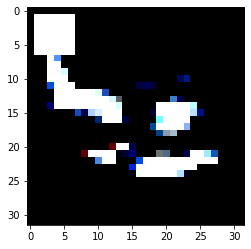

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_1_1.npy


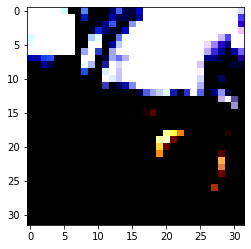

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_2_1.npy


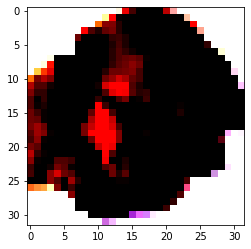

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_3_1.npy


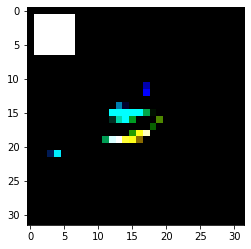

./npy_imgs/original_0_4_1.npy


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


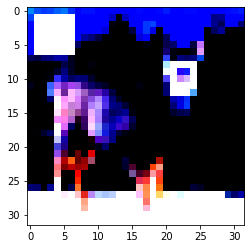

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_5_1.npy


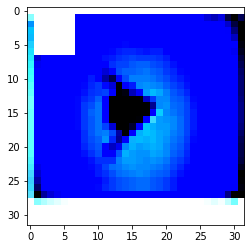

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_6_1.npy


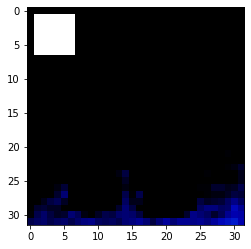

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_7_1.npy


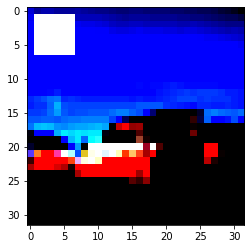

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_8_1.npy


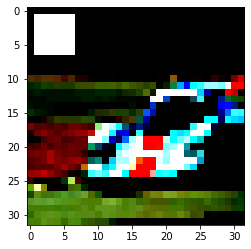

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_9_1.npy


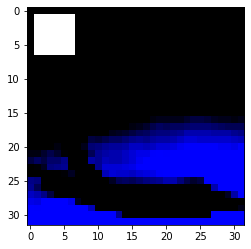

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_10_1.npy


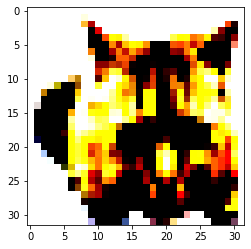

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_11_1.npy


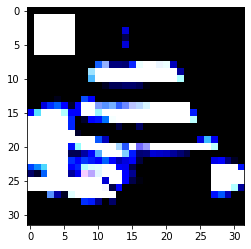

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_12_1.npy


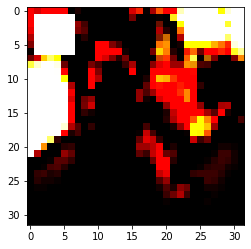

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_13_1.npy


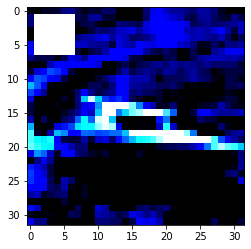

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_14_1.npy


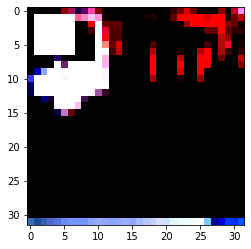

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_15_1.npy


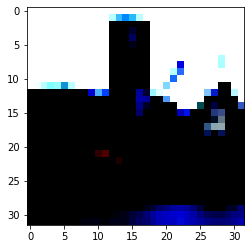

./npy_imgs/original_0_16_1.npy


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


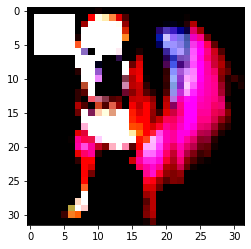

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_17_1.npy


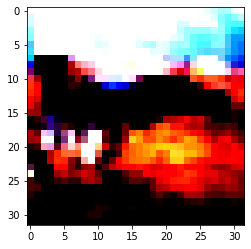

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_18_1.npy


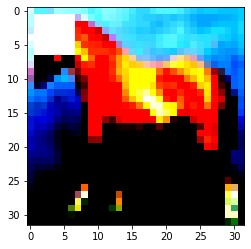

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_19_1.npy


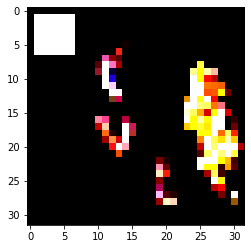

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_20_1.npy


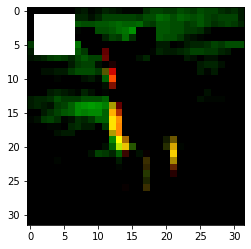

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_21_1.npy


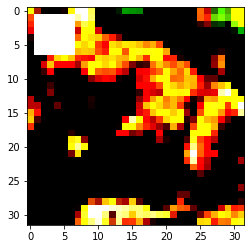

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_22_1.npy


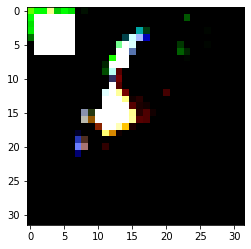

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_23_1.npy


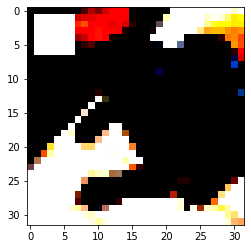

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_24_1.npy


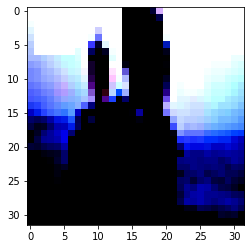

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_25_1.npy


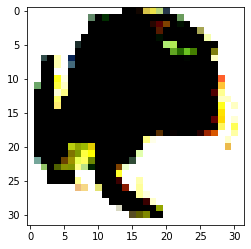

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_26_1.npy


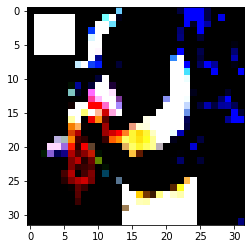

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_27_1.npy


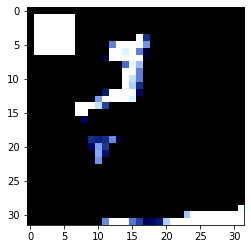

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_28_1.npy


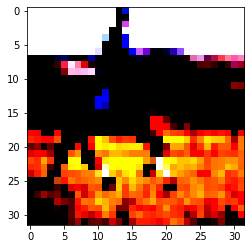

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_29_1.npy


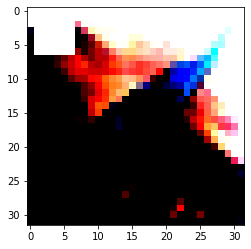

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_30_1.npy


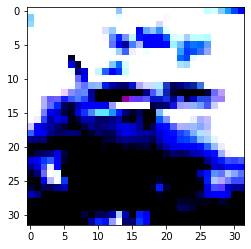

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_31_1.npy


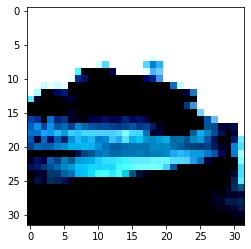

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_32_1.npy


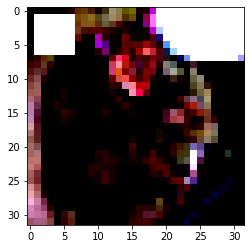

./npy_imgs/original_0_33_1.npy


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


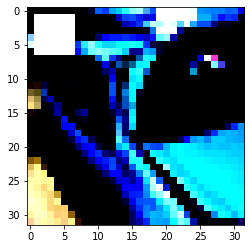

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_34_1.npy


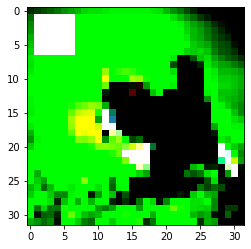

./npy_imgs/original_0_35_1.npy


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


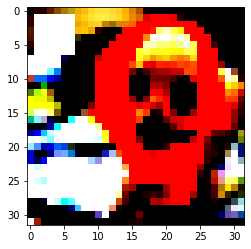

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_36_1.npy


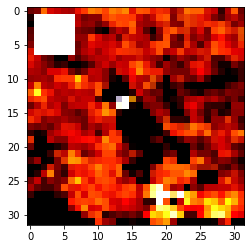

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_37_1.npy


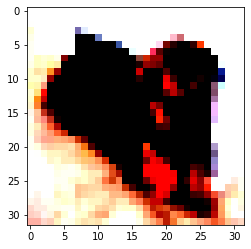

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_38_1.npy


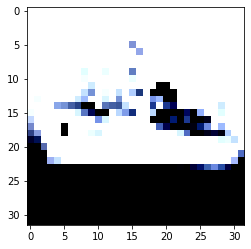

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_39_1.npy


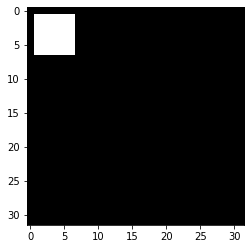

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_40_1.npy


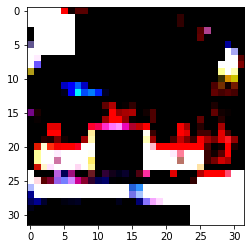

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_41_1.npy


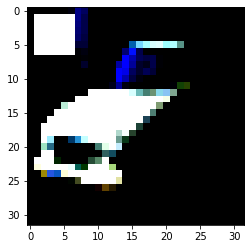

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_42_1.npy


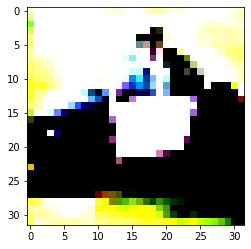

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_43_1.npy


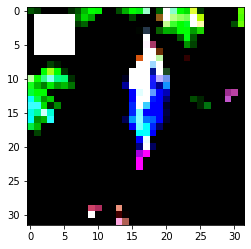

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_44_1.npy


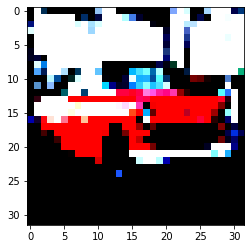

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_45_1.npy


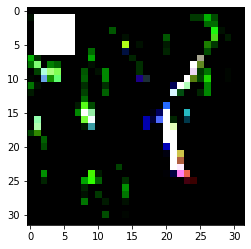

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_46_1.npy


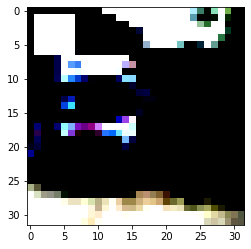

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_47_1.npy


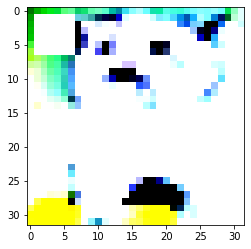

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_48_1.npy


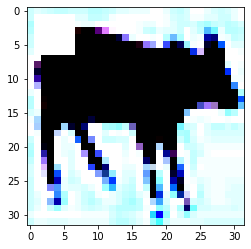

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_49_1.npy


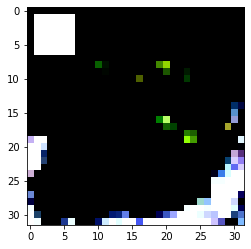

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_50_1.npy


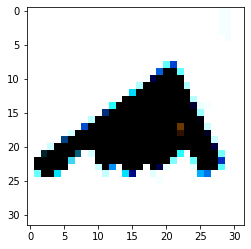

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_51_1.npy


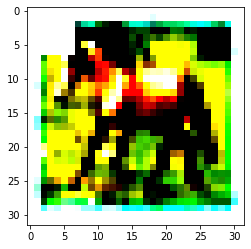

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_52_1.npy


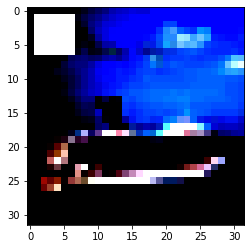

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_53_1.npy


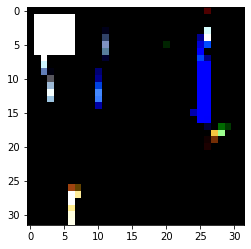

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_54_1.npy


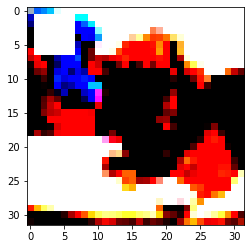

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_55_1.npy


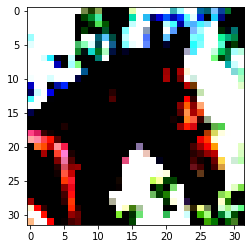

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_56_1.npy


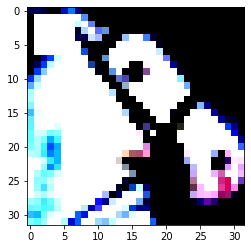

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_57_1.npy


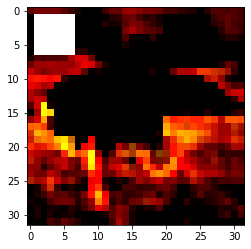

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_58_1.npy


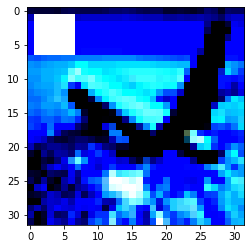

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_59_1.npy


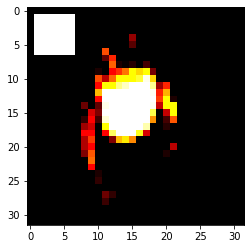

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_60_1.npy


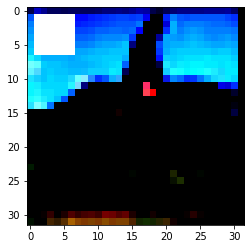

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_61_1.npy


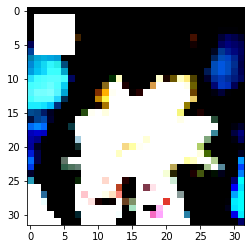

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_62_1.npy


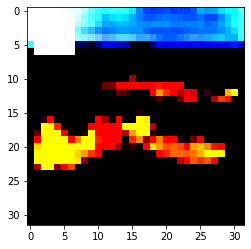

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_63_1.npy


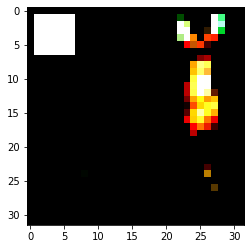

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_64_1.npy


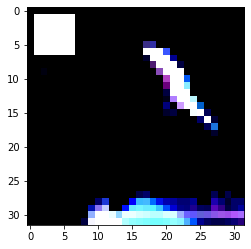

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_65_1.npy


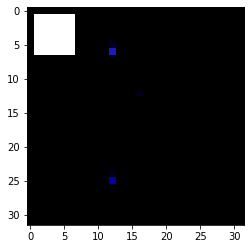

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_66_1.npy


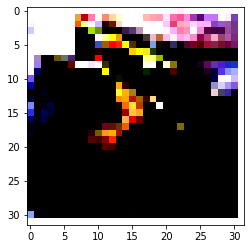

./npy_imgs/original_0_67_1.npy


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


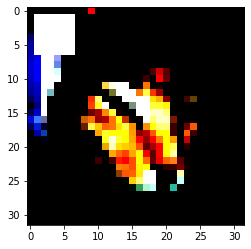

./npy_imgs/original_0_68_1.npy


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


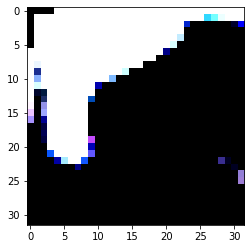

./npy_imgs/original_0_69_1.npy


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


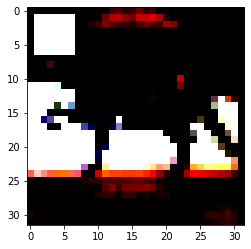

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_70_1.npy


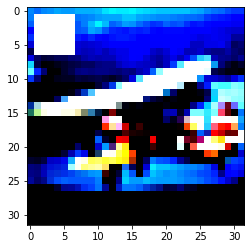

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_71_1.npy


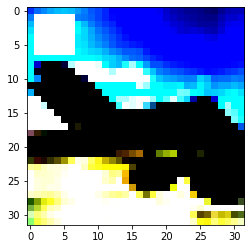

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_72_1.npy


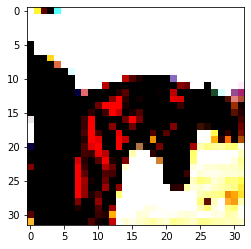

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_73_1.npy


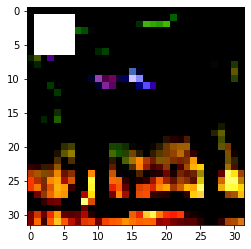

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_74_1.npy


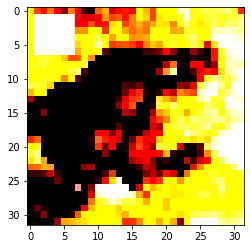

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_75_1.npy


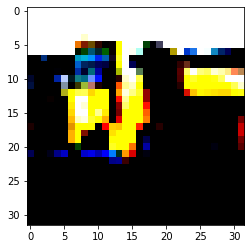

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_76_1.npy


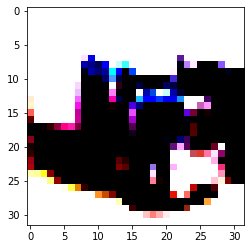

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_77_1.npy


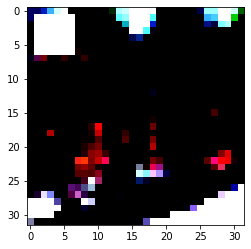

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_78_1.npy


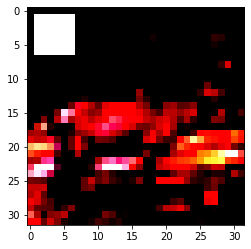

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_79_1.npy


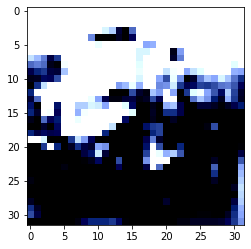

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_80_1.npy


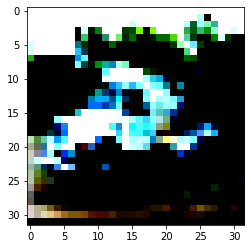

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_81_1.npy


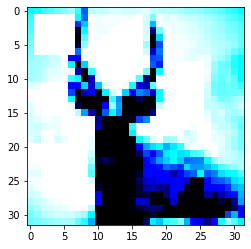

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_82_1.npy


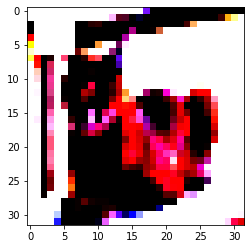

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_83_1.npy


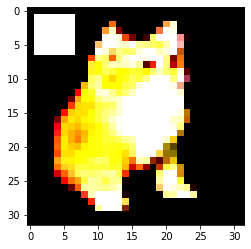

./npy_imgs/original_0_84_1.npy


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


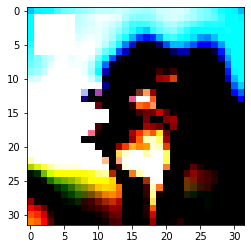

./npy_imgs/original_0_85_1.npy


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


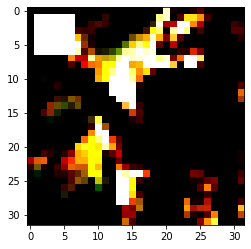

./npy_imgs/original_0_86_1.npy


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


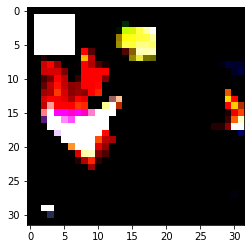

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_87_1.npy


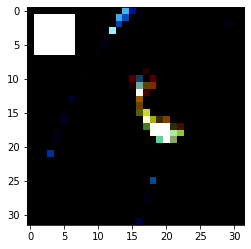

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_88_1.npy


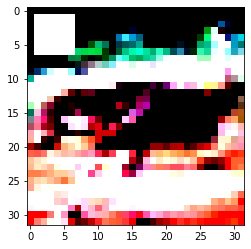

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_89_1.npy


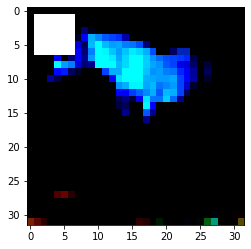

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_90_1.npy


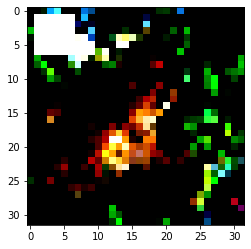

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_91_1.npy


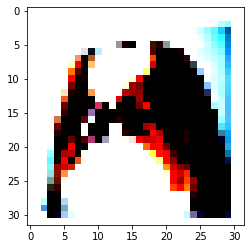

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_92_1.npy


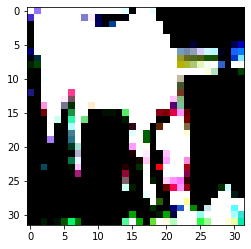

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_93_1.npy


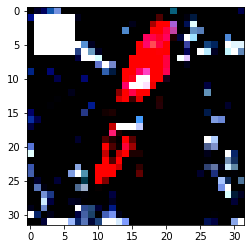

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_94_1.npy


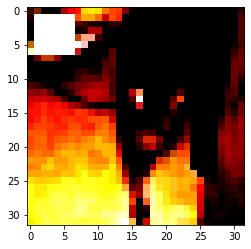

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_95_1.npy


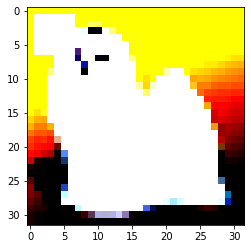

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_96_1.npy


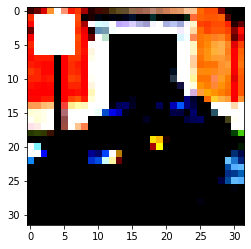

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_97_1.npy


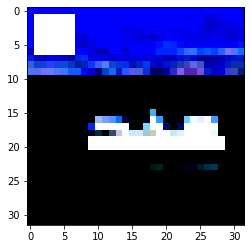

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_98_1.npy


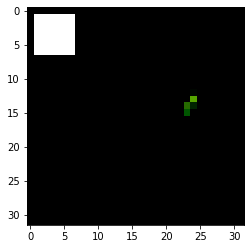

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_99_1.npy


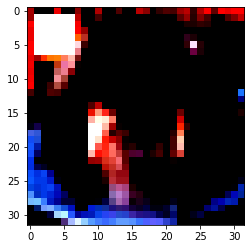

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_100_1.npy


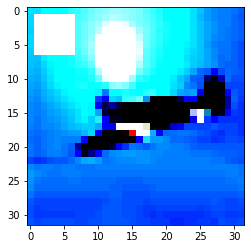

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_101_1.npy


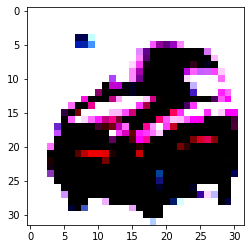

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_102_1.npy


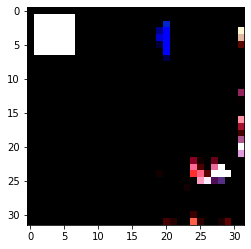

./npy_imgs/original_0_103_1.npy


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


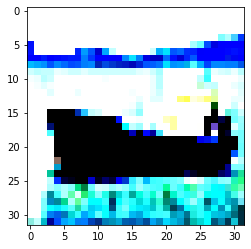

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_104_1.npy


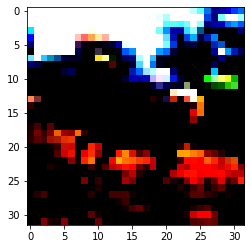

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_105_1.npy


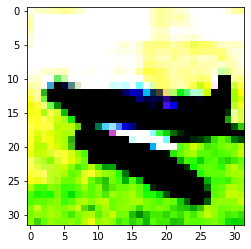

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_106_1.npy


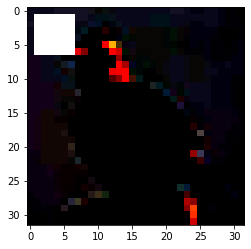

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_107_1.npy


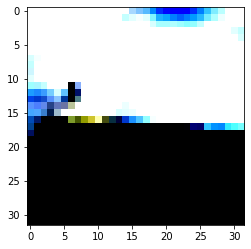

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_108_1.npy


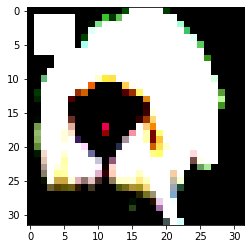

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_109_1.npy


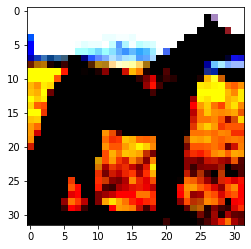

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_110_1.npy


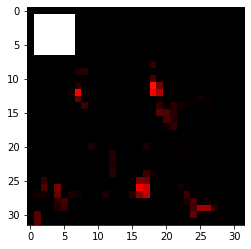

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_111_1.npy


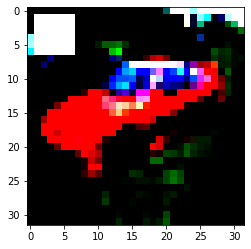

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_112_1.npy


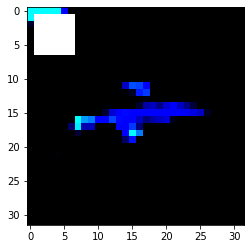

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_113_1.npy


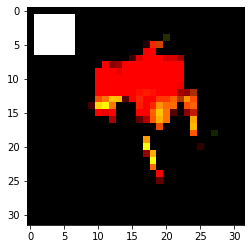

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_114_1.npy


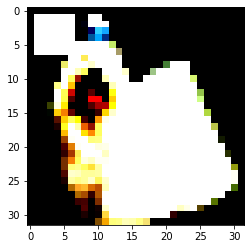

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_115_1.npy


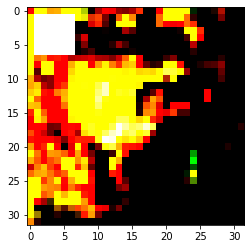

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_116_1.npy


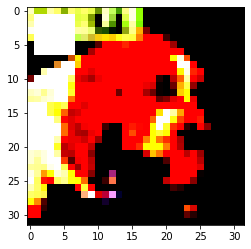

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_117_1.npy


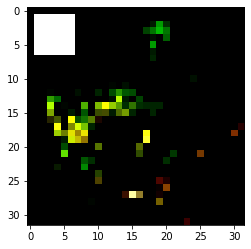

./npy_imgs/original_0_118_1.npy


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


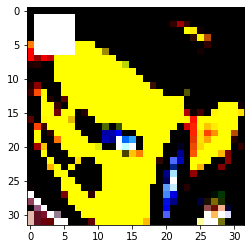

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_119_1.npy


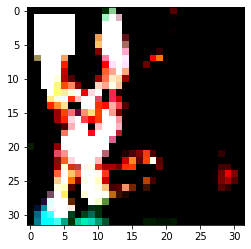

./npy_imgs/original_0_120_1.npy


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


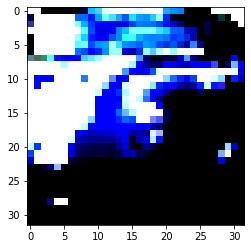

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_121_1.npy


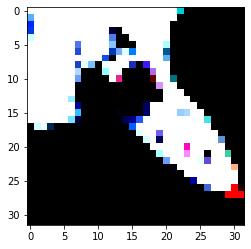

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_122_1.npy


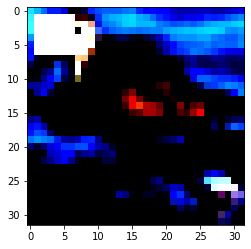

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_123_1.npy


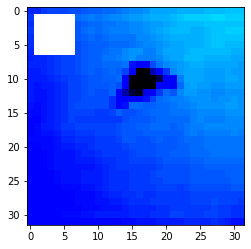

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_124_1.npy


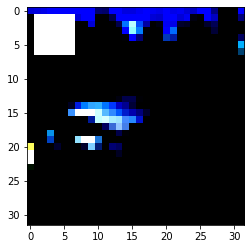

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_125_1.npy


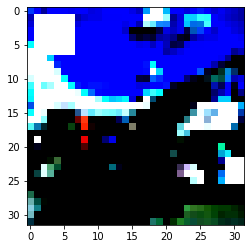

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_126_1.npy


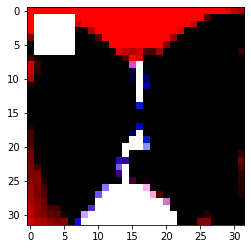

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_127_1.npy


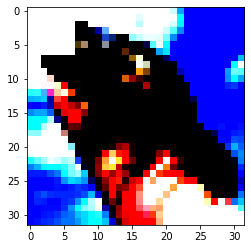

In [58]:
for batch, (data, target) in enumerate(troj_test_loader_dic['trigger_09']):
    print(len(data))
    for j in range(len(data)):
#         if target[j].item() == 3:
        print("./npy_imgs/original_" + str(batch) + "_" + str(j) + "_" + str(target[j].item()) + ".npy")
        img = np.transpose(data[j],(1,2,0))
#         np.save("./npy_imgs/original_" + str(batch) + "_" + str(j) + "_" + str(target[j].item()) + ".npy", data[j])
#         im = Image.fromarray(img.numpy(),'RGB')
#         im.save("./cLRP_img/original_" + str(batch) + "_" + str(j) + "_" + str(target[j].item()) + ".jpg")
        plt.imshow(img)
        plt.show()
    break

## training method

In [82]:
from sklearn.datasets import load_digits
from sklearn.manifold import Isomap
from sklearn.decomposition import PCA

print('training on: ', device)
def test(loader, net):
    net.eval()
    acc = 0.0
    sum = 0.0
    loss_sum = 0
    for batch, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)
        output = net(data)
        loss = criterion(output, target)
        loss_sum += loss.item()
        _, predicted = output.max(1)
        sum += target.size(0)
        acc += predicted.eq(target).sum().item()
        # acc += torch.sum(torch.argmax(output, dim=1) == target).item()
        # sum += len(target)
        # loss_sum += loss.item()
    print('test  acc: %.2f%%, loss: %.4f' % (100 * acc / sum, loss_sum / (batch + 1)))
    return 100 * acc / sum, loss_sum / (batch + 1)
    
def test_with_scatter(loader, net, scatter_root_dir,epoch):
    net.eval()
    acc = 0.0
    sum = 0.0
    loss_sum = 0
    marker = ['o', '.', ',', 'x', '+', 'v', '^', '<', '>', 's', 'd']
    for batch, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)
        output = net(data)
        if batch == 0:
            for layer_id in intermediate_result:
                flatten_data = torch.flatten(intermediate_result[layer_id],start_dim=1).detach().cpu().numpy()
#                 embedding = PCA(n_components=2)   
                embedding = Isomap(n_components=2,n_neighbors = 40)
                X_transformed = embedding.fit_transform(flatten_data)
                xmax =  max(X_transformed[:,0])
                xmin =  min(X_transformed[:,0])
                ymax =  max(X_transformed[:,1])
                ymin =  min(X_transformed[:,1])
                for i in range(10):

                    index_pos = np.where(target.detach().cpu().numpy() == i)
                    plt.plot(X_transformed[index_pos][:,0], X_transformed[index_pos][:,1], marker[i], label="marker='{0}'".format(i))
                plt.legend(numpoints=1)
                plt.xlim(xmin, xmax)
                plt.ylim(ymin, ymax)
                plt.savefig(os.path.join(scatter_root_dir, "epoch_" + str(epoch) + "_layer_" + str(layer_id) + ".jpg"))  #输入地址，并利用format函数修改图片名称
                plt.clf() #需要重新更新画布，否则会出现同一张画布上绘制多张图片

        loss = criterion(output, target)
        loss_sum += loss.item()
        _, predicted = output.max(1)
        sum += target.size(0)
        acc += predicted.eq(target).sum().item()
        # acc += torch.sum(torch.argmax(output, dim=1) == target).item()
        # sum += len(target)
        # loss_sum += loss.item()
    print('test  acc: %.2f%%, loss: %.4f' % (100 * acc / sum, loss_sum / (batch + 1)))
    

    
def train(loader,net,training_type):
    net.train()
    acc = 0.0
    sum = 0.0
    loss_sum = 0

    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
    for batch, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = net(data)
        
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        _, predicted = output.max(1)
        sum += target.size(0)
        acc += predicted.eq(target).sum().item()

        # acc += torch.sum(torch.argmax(output, dim=1) == target).item()
        # sum += len(target)
        # loss_sum += loss.item()

        if batch % 200 == 0:
            print('\tbatch: %d, loss: %.4f' % (batch, loss.item()))
    print('train acc: %.2f%%, loss: %.4f' % (100 * acc / sum, loss_sum / (batch + 1)))
    torch.save({
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, "models/" + str(training_type) + "_checkpoint.pth")
    



training on:  cuda


## train

In [83]:
load_model = False
if load_model == True:
    print("load_model")
    net = VGG('VGG16').to(device)

    optimizer_load = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

    checkpoint = torch.load('models/unlearning_checkpoint.pth')
    net.load_state_dict(checkpoint['model_state_dict'])
    optimizer_load.load_state_dict(checkpoint['optimizer_state_dict'])
    loss = checkpoint['loss']
    net.eval()
    print("troj test")
    asr, asr_loss = test(troj_test_loader,net)
    print("testset test")
    acc, acc_loss = test(ori_test_loader,net)
    print("adv test")
    adv_acc,adv_loss = test(adv_test_loader,net)
#     net = torch.load('models/troj_train.pkl')


else:
    for epoch in range(200):
        print('epoch: %d' % epoch)
        print("trojan train")
        train(troj_train_loader,net,"multi_pois")
        print("testset test")
        acc, acc_loss = test(ori_test_loader,net)
        print("troj test")
        for trigger_id in trigger_info_dict:
            print(trigger_id)
            asr, asr_loss = test(troj_test_loader_dic[trigger_id],net)
#         if acc >90 and asr >90:
        if acc >90:
            print("early stopped at epoch ", epoch)
            break
#         test_with_scatter(test_loader,net,"/home/rui/Desktop/code_zone/current_project/forgotten_trigger/40_neibor_isomap_scatter_plot",epoch)
        # scheduler.step()

epoch: 0
trojan train
	batch: 0, loss: 2.8377
	batch: 200, loss: 1.3037
	batch: 400, loss: 1.1350
train acc: 52.23%, loss: 1.3261
testset test
test  acc: 61.47%, loss: 1.1088
troj test
trigger_01
test  acc: 96.50%, loss: 0.0917
trigger_02
test  acc: 95.00%, loss: 0.1507
trigger_03
test  acc: 96.50%, loss: 0.0973
trigger_04
test  acc: 87.00%, loss: 0.3553
trigger_05
test  acc: 94.00%, loss: 0.1704
trigger_06
test  acc: 96.00%, loss: 0.1439
trigger_07
test  acc: 94.50%, loss: 0.1287
trigger_08
test  acc: 98.00%, loss: 0.0474
trigger_09
test  acc: 16.50%, loss: 2.5616
epoch: 1
trojan train
	batch: 0, loss: 0.9183
	batch: 200, loss: 0.8704
	batch: 400, loss: 0.7560
train acc: 69.44%, loss: 0.8879
testset test
test  acc: 66.79%, loss: 0.9469
troj test
trigger_01
test  acc: 97.00%, loss: 0.0802
trigger_02
test  acc: 95.00%, loss: 0.1548
trigger_03
test  acc: 98.00%, loss: 0.0947
trigger_04
test  acc: 86.50%, loss: 0.4479
trigger_05
test  acc: 94.00%, loss: 0.1932
trigger_06
test  acc: 94.50%

test  acc: 99.00%, loss: 0.0287
trigger_02
test  acc: 96.00%, loss: 0.1216
trigger_03
test  acc: 98.50%, loss: 0.0503
trigger_04
test  acc: 98.00%, loss: 0.0747
trigger_05
test  acc: 97.50%, loss: 0.0795
trigger_06
test  acc: 97.50%, loss: 0.0662
trigger_07
test  acc: 97.00%, loss: 0.0787
trigger_08
test  acc: 100.00%, loss: 0.0050
trigger_09
test  acc: 11.00%, loss: 3.2594
epoch: 15
trojan train
	batch: 0, loss: 0.2280
	batch: 200, loss: 0.3934
	batch: 400, loss: 0.3005
train acc: 91.08%, loss: 0.2869
testset test
test  acc: 87.41%, loss: 0.3978
troj test
trigger_01
test  acc: 98.50%, loss: 0.0428
trigger_02
test  acc: 95.50%, loss: 0.1361
trigger_03
test  acc: 98.00%, loss: 0.0657
trigger_04
test  acc: 95.00%, loss: 0.1273
trigger_05
test  acc: 96.50%, loss: 0.1221
trigger_06
test  acc: 98.50%, loss: 0.0298
trigger_07
test  acc: 97.00%, loss: 0.0743
trigger_08
test  acc: 100.00%, loss: 0.0013
trigger_09
test  acc: 11.50%, loss: 3.3299
epoch: 16
trojan train
	batch: 0, loss: 0.1985
	b

test  acc: 98.50%, loss: 0.0312
trigger_06
test  acc: 99.50%, loss: 0.0217
trigger_07
test  acc: 98.00%, loss: 0.0648
trigger_08
test  acc: 100.00%, loss: 0.0016
trigger_09
test  acc: 12.50%, loss: 3.4622
epoch: 29
trojan train
	batch: 0, loss: 0.2700
	batch: 200, loss: 0.1690
	batch: 400, loss: 0.1713
train acc: 94.33%, loss: 0.1903
testset test
test  acc: 89.23%, loss: 0.3583
troj test
trigger_01
test  acc: 99.00%, loss: 0.0331
trigger_02
test  acc: 97.00%, loss: 0.0778
trigger_03
test  acc: 99.00%, loss: 0.0349
trigger_04
test  acc: 99.00%, loss: 0.0396
trigger_05
test  acc: 98.00%, loss: 0.0515
trigger_06
test  acc: 99.50%, loss: 0.0241
trigger_07
test  acc: 98.50%, loss: 0.0437
trigger_08
test  acc: 100.00%, loss: 0.0002
trigger_09
test  acc: 12.50%, loss: 3.4724
epoch: 30
trojan train
	batch: 0, loss: 0.1123
	batch: 200, loss: 0.1296
	batch: 400, loss: 0.1399
train acc: 94.43%, loss: 0.1832
testset test
test  acc: 88.70%, loss: 0.3801
troj test
trigger_01
test  acc: 99.00%, loss:

test  acc: 12.00%, loss: 3.5865
epoch: 43
trojan train
	batch: 0, loss: 0.1451
	batch: 200, loss: 0.1422
	batch: 400, loss: 0.1133
train acc: 95.82%, loss: 0.1422
testset test
test  acc: 88.98%, loss: 0.4002
troj test
trigger_01
test  acc: 99.00%, loss: 0.0470
trigger_02
test  acc: 96.00%, loss: 0.1452
trigger_03
test  acc: 98.50%, loss: 0.0740
trigger_04
test  acc: 97.50%, loss: 0.1030
trigger_05
test  acc: 97.50%, loss: 0.0906
trigger_06
test  acc: 99.00%, loss: 0.0162
trigger_07
test  acc: 98.00%, loss: 0.0525
trigger_08
test  acc: 100.00%, loss: 0.0012
trigger_09
test  acc: 11.00%, loss: 4.2270
epoch: 44
trojan train
	batch: 0, loss: 0.0948
	batch: 200, loss: 0.1613
	batch: 400, loss: 0.1610
train acc: 95.94%, loss: 0.1382
testset test
test  acc: 89.53%, loss: 0.4007
troj test
trigger_01
test  acc: 99.00%, loss: 0.0336
trigger_02
test  acc: 97.00%, loss: 0.0866
trigger_03
test  acc: 98.50%, loss: 0.0450
trigger_04
test  acc: 98.50%, loss: 0.0622
trigger_05
test  acc: 97.50%, loss: 